In [1]:
# download temp mean data for Global 2m temps (GFS Ensemble 0.5 Degree Bias-Corrected)
# doc: at https://nomads.ncep.noaa.gov/
# this will take multiple minutes
import os
import requests
import time
from bs4 import BeautifulSoup
ts = ['00', '06', '12', '18']
t = ts[0]

# CONFIGURATION FOR FORECASTS TO DOWNLOAD (only last two days are available)
# MAKE SURE THERE IS NO TRAILING SLASH
base_urls = [
    "https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/gefs.20230812/" + t + "/pgrb2ap5_bc"
]

def download_file(url, folder_path):
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'wb') as f:
        f.write(response.content)

def get_file_urls(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and not href.startswith('../') and href.startswith('geavg.t' + t + 'z.pgrb2a.0p50_bcf') and 'idx' not in href:
            urls.append(href)
    return urls

num_urls = len(base_urls)
cur_url_count = 0
for base_url in base_urls:
    folder_path = os.path.basename(os.path.normpath(
        base_url.split('/')[-3]
    ))
    folder_path += '_' + t
    print(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    cur_url_count += 1
    print(f"Processing {cur_url_count} / {num_urls} folders to download GEFS, bias corrected, 2m ensemble mean temperatures")

    file_urls = get_file_urls(base_url)
    time.sleep(2)
    i = 0
    numfiles = len(file_urls)
    for file_url in file_urls:
        download_url = f"https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/{base_url.split('https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/')[-1]}&file={file_url}&var_TMP=on&lev_2_m_above_ground=on"
        i += 1
        print(f" - Downloading {i} / {numfiles} : {download_url}")
        download_file(download_url, folder_path)
        time.sleep(2)  # Pause for 2 seconds between downloads

gefs.20230812_00
Processing 1 / 1 folders to download GEFS, bias corrected, 2m ensemble mean temperatures
 - Downloading 1 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf003&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 2 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf006&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 3 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf009&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 4 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf012&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 5 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf015&var_TMP=on&lev_2_m_

 - Downloading 46 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf138&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 47 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf141&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 48 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf144&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 49 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf147&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 50 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf150&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 51 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

 - Downloading 91 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf354&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 92 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf360&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 93 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf366&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 94 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf372&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 95 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20230812/00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf378&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 96 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

In [2]:
# calculate averages for downloaded forecast data

import pygrib
import numpy as np
from datetime import datetime, timedelta
import os
import glob

def get_date_from_offset(date_string, offset_hours):
    date_format = "%Y%m%d"
    date = datetime.strptime(date_string, date_format)
    result_date = date + timedelta(hours=offset_hours)
    return result_date

def date_to_time_str(date_time):
    date_format = "%Y-%m-%d %H:%M:%S"
    time_str = date_time.strftime(date_format)
    return time_str

def date_to_day_str(date_time):
    date_format = "%m-%d-%Y"
    month_day_year = date_time.strftime(date_format)
    return month_day_year

def day_str_to_date(date_string):
    date_format = "%m-%d-%Y"
    date = datetime.strptime(date_string, date_format)
    return date

def kelvin_to_celsius(kelvin_temperature):
    celsius_temperature = kelvin_temperature - 273.15
    return celsius_temperature

def get_average_temperature(file_path):
    grbs = pygrib.open(file_path)
    # first get the forecast avg temp for that time step
    forecast_temperatures = {}
    for grb in grbs:
        # there should only be one entry even this is a for loop
        date = grb.dataDate
        # hours offset from forecast
        forecastTime = grb.forecastTime
        # calculate the valid time for this data
        valid_time = get_date_from_offset(str(date), forecastTime)
        time_str = date_to_time_str(valid_time)
            
        # each step is in units of hours, with intervals of every 3 hours
        # this is a forecast so the first hour is missing (only in analysis data)
        # there should only be one value
        if '2 metre temperature' in grb.name:
            avg = kelvin_to_celsius(grb.average)
            forecast_temperatures[valid_time] = avg
    grbs.close()
    return forecast_temperatures

def process_files_in_folder(folder_path):
    file_list = sorted(glob.glob(os.path.join(folder_path, "*")))
    num_files = len(file_list)
    print(f"--   Processing {num_files} files...")
    last_date = None
    max_temp = None
    averages_for_folder = []
    forecast_temperatures = {}
    complete_averages = {}
    # keep track of first day to skip adding it to complete_averages
    first_day = True
    for file_path in file_list:
        # get average temperature for step (should only be one time step)
        forecast_temperatures.update(get_average_temperature(file_path))
    
    # calculate the average for each day
    last_day_str = None
    day_averages = []
    last_avg = None
    for valid_time, avg in forecast_temperatures.items():
        # handle case for first observation
        if last_day_str is None:
            last_day_str = date_to_day_str(valid_time)

        day_str = date_to_day_str(valid_time)
        if day_str == last_day_str:
            # time step in same day
            day_averages.append(avg)
        else:
            # time step goes to next day
            # print out the previous day's average first
            
            day_average = np.average(day_averages)
            if last_avg == None:
                last_avg = day_average
            day_over_day_delta = day_average - last_avg
            if not first_day or len(day_averages) != 7:
                print(f"Global 2m temp average (C) for {last_day_str}: {day_average:6.3f} (day over day delta: {day_over_day_delta:6.3f})")
                yesterday_time = day_str_to_date(last_day_str)
                complete_averages[yesterday_time] = day_average
            # clear the list for the new day
            day_averages = []
            # change the last_day
            last_day_str = day_str
            # add the current day's average to the list
            day_averages.append(avg)
            last_avg = day_average

            # set first day done
            first_day = False
    return complete_averages

In [3]:
## CONFIGURE TO FOLDER NAMES
#folders = ["gefs.20230726", "gefs.20230727", "gefs.20230728", "gefs.20230729", "gefs.20230730", "gefs.20230731", "gefs.20230801", "gefs.20230802", "gefs.20230803", "gefs.20230804", "gefs.20230805", "gefs.20230805_12", "gefs.20230805_18", "gefs.20230806"]  # Add more folders if needed
# Get a list of all items in the current directory
items = os.listdir()
# Filter out only the folder names
unsorted_folders = [item for item in items if os.path.isdir(item)]
# Sort the folder names in alphabetical order
folders = sorted(unsorted_folders)
complete_averages = {}

for folder in folders:
    if 'gefs' in folder:
        folder_path = os.path.join(".", folder)  # Adjust the path if 
        print(f"-- Processing {folder_path}")
        complete_averages[folder] = process_files_in_folder(folder_path)

-- Processing ./gefs.20230726_00
--   Processing 96 files...
Global 2m temp average (C) for 07-27-2023:  8.565 (day over day delta:  0.070)
Global 2m temp average (C) for 07-28-2023:  8.568 (day over day delta:  0.003)
Global 2m temp average (C) for 07-29-2023:  8.280 (day over day delta: -0.288)
Global 2m temp average (C) for 07-30-2023:  8.160 (day over day delta: -0.120)
Global 2m temp average (C) for 07-31-2023:  8.113 (day over day delta: -0.047)
Global 2m temp average (C) for 08-01-2023:  8.224 (day over day delta:  0.111)
Global 2m temp average (C) for 08-02-2023:  8.393 (day over day delta:  0.170)
Global 2m temp average (C) for 08-03-2023:  8.540 (day over day delta:  0.147)
Global 2m temp average (C) for 08-04-2023:  8.674 (day over day delta:  0.134)
Global 2m temp average (C) for 08-05-2023:  8.687 (day over day delta:  0.013)
Global 2m temp average (C) for 08-06-2023:  8.655 (day over day delta: -0.032)
Global 2m temp average (C) for 08-07-2023:  8.576 (day over day delta:

Global 2m temp average (C) for 08-03-2023:  8.627 (day over day delta:  0.020)
Global 2m temp average (C) for 08-04-2023:  8.667 (day over day delta:  0.040)
Global 2m temp average (C) for 08-05-2023:  8.620 (day over day delta: -0.047)
Global 2m temp average (C) for 08-06-2023:  8.346 (day over day delta: -0.275)
Global 2m temp average (C) for 08-07-2023:  8.263 (day over day delta: -0.082)
Global 2m temp average (C) for 08-08-2023:  8.045 (day over day delta: -0.218)
Global 2m temp average (C) for 08-09-2023:  7.883 (day over day delta: -0.162)
Global 2m temp average (C) for 08-10-2023:  7.827 (day over day delta: -0.057)
Global 2m temp average (C) for 08-11-2023:  7.799 (day over day delta: -0.028)
Global 2m temp average (C) for 08-12-2023:  7.799 (day over day delta: -0.000)
Global 2m temp average (C) for 08-13-2023:  7.821 (day over day delta:  0.022)
Global 2m temp average (C) for 08-14-2023:  7.873 (day over day delta:  0.052)
Global 2m temp average (C) for 08-15-2023:  7.942 (d

Global 2m temp average (C) for 08-07-2023:  8.183 (day over day delta: -0.159)
Global 2m temp average (C) for 08-08-2023:  8.224 (day over day delta:  0.041)
Global 2m temp average (C) for 08-09-2023:  8.156 (day over day delta: -0.068)
Global 2m temp average (C) for 08-10-2023:  8.040 (day over day delta: -0.116)
Global 2m temp average (C) for 08-11-2023:  7.986 (day over day delta: -0.054)
Global 2m temp average (C) for 08-12-2023:  8.088 (day over day delta:  0.102)
Global 2m temp average (C) for 08-13-2023:  8.096 (day over day delta:  0.008)
Global 2m temp average (C) for 08-14-2023:  8.017 (day over day delta: -0.079)
Global 2m temp average (C) for 08-15-2023:  8.003 (day over day delta: -0.013)
Global 2m temp average (C) for 08-16-2023:  8.022 (day over day delta:  0.018)
Global 2m temp average (C) for 08-17-2023:  7.976 (day over day delta: -0.046)
Global 2m temp average (C) for 08-18-2023:  7.925 (day over day delta: -0.051)
Global 2m temp average (C) for 08-19-2023:  7.928 (d

Global 2m temp average (C) for 08-08-2023:  7.964 (day over day delta: -0.048)
Global 2m temp average (C) for 08-09-2023:  7.794 (day over day delta: -0.170)
Global 2m temp average (C) for 08-10-2023:  7.626 (day over day delta: -0.168)
Global 2m temp average (C) for 08-11-2023:  7.497 (day over day delta: -0.129)
Global 2m temp average (C) for 08-12-2023:  7.654 (day over day delta:  0.157)
Global 2m temp average (C) for 08-13-2023:  7.733 (day over day delta:  0.079)
Global 2m temp average (C) for 08-14-2023:  7.738 (day over day delta:  0.005)
Global 2m temp average (C) for 08-15-2023:  7.785 (day over day delta:  0.047)
Global 2m temp average (C) for 08-16-2023:  7.904 (day over day delta:  0.119)
Global 2m temp average (C) for 08-17-2023:  7.924 (day over day delta:  0.020)
Global 2m temp average (C) for 08-18-2023:  8.057 (day over day delta:  0.132)
Global 2m temp average (C) for 08-19-2023:  8.115 (day over day delta:  0.058)
Global 2m temp average (C) for 08-20-2023:  8.209 (d

Global 2m temp average (C) for 08-10-2023:  7.625 (day over day delta: -0.026)
Global 2m temp average (C) for 08-11-2023:  7.539 (day over day delta: -0.085)
Global 2m temp average (C) for 08-12-2023:  7.740 (day over day delta:  0.201)
Global 2m temp average (C) for 08-13-2023:  7.907 (day over day delta:  0.166)
Global 2m temp average (C) for 08-14-2023:  7.919 (day over day delta:  0.012)
Global 2m temp average (C) for 08-15-2023:  7.921 (day over day delta:  0.003)
Global 2m temp average (C) for 08-16-2023:  7.845 (day over day delta: -0.076)
Global 2m temp average (C) for 08-17-2023:  7.799 (day over day delta: -0.046)
Global 2m temp average (C) for 08-18-2023:  7.911 (day over day delta:  0.112)
Global 2m temp average (C) for 08-19-2023:  7.905 (day over day delta: -0.006)
Global 2m temp average (C) for 08-20-2023:  7.958 (day over day delta:  0.053)
Global 2m temp average (C) for 08-21-2023:  8.076 (day over day delta:  0.118)
Global 2m temp average (C) for 08-22-2023:  8.162 (d

Global 2m temp average (C) for 08-12-2023:  7.688 (day over day delta:  0.171)
Global 2m temp average (C) for 08-13-2023:  7.901 (day over day delta:  0.212)
Global 2m temp average (C) for 08-14-2023:  7.813 (day over day delta: -0.088)
Global 2m temp average (C) for 08-15-2023:  7.910 (day over day delta:  0.097)
Global 2m temp average (C) for 08-16-2023:  8.058 (day over day delta:  0.148)
Global 2m temp average (C) for 08-17-2023:  7.915 (day over day delta: -0.143)
Global 2m temp average (C) for 08-18-2023:  7.919 (day over day delta:  0.004)
Global 2m temp average (C) for 08-19-2023:  7.970 (day over day delta:  0.051)
Global 2m temp average (C) for 08-20-2023:  7.956 (day over day delta: -0.014)
Global 2m temp average (C) for 08-21-2023:  8.106 (day over day delta:  0.150)
Global 2m temp average (C) for 08-22-2023:  8.298 (day over day delta:  0.192)
Global 2m temp average (C) for 08-23-2023:  8.339 (day over day delta:  0.041)
Global 2m temp average (C) for 08-24-2023:  8.303 (d

In [4]:
# strip plot for each day

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def graph_strip_plot(forecast, record):
    fig, ax = plt.subplots(figsize=(8, 12))
    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []

    for date, temps in forecast.items():
        data.extend(temps)
        # treat the date as a whole string
        labels.extend([date] * len(temps))
        #hue.extend(['Forecast'] * len(temps))

    #print(labels)
    #print(data)
    # Set the style of the strip plot
    sns.stripplot(x=labels, y=data, dodge=True, alpha=0.9, linewidth=0)

    # Add a horizontal line at the rise threshold
    ax.axhline(y=record, color='g', linestyle='--')

    # Set the y-axis label
    ax.set_ylabel('Forecast Global Avg. Temperature (C)')

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set more subticks on the y-axis
    #plt.yticks(np.arange(-1.0, 1.6, 0.1))

    # Increase spacing between each day
    #plt.subplots_adjust(wspace=0.6)
        
    # Add a title to the chart
    plt.title('Forecasted Global Daily Temperature Averages' + '\n' + 
              'Derived from GEFS (Bias-Corrected, Mean) 2m Temperature Forecasts'
    )

    # Show the plot
    plt.show()

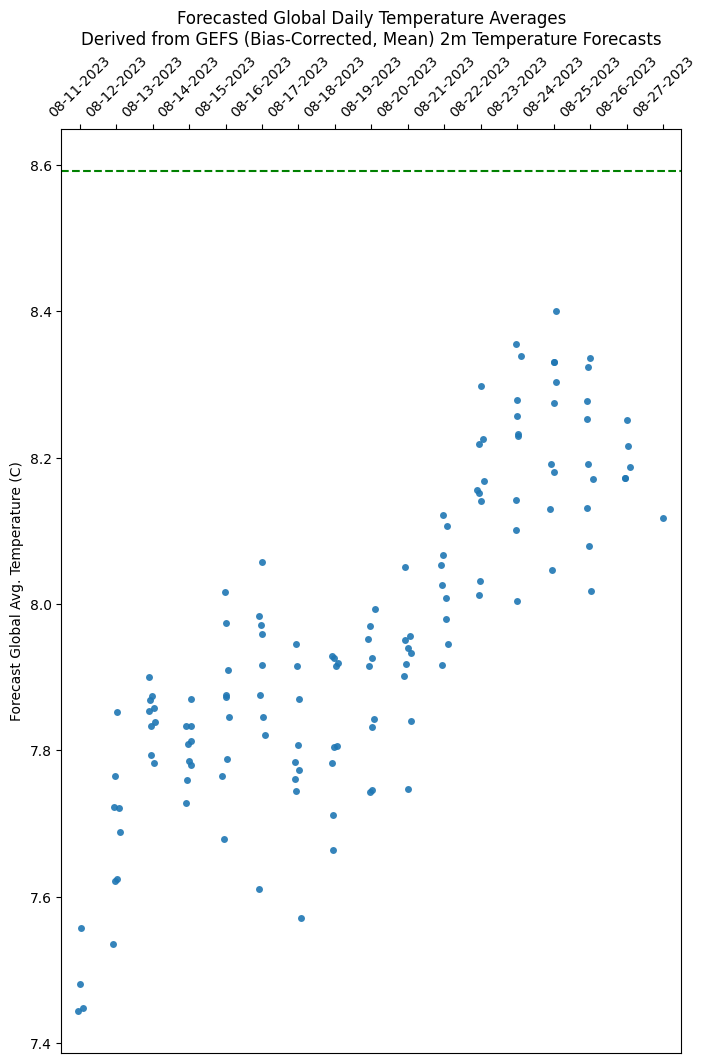

In [6]:
forecast = {}

# exclude forecasts older than this date, or set to None for ALL
min_forecast_date = "2023-08-10"
#min_forecast_date = "2023-07-26"

for folder_name, complete_average in complete_averages.items():
    # each forecast has a set of forecast dates
    # use if want to prune old forecasts
    short_date = folder_name.split('.')[1].split('_')[0]
    

    # Date to compare in the format YYYY-MM-DD
    if min_forecast_date:
        compare_date = datetime.strptime(min_forecast_date, "%Y-%m-%d")
    else:
        compare_date = None

    # Convert the short date to a comparable format
    short_date_dt = datetime.strptime(short_date, "%Y%m%d")
    # Compare the dates
    if not compare_date or compare_date <= short_date_dt:
        for valid_time, forecast_average in complete_average.items():
            day_str = date_to_day_str(valid_time)
            if day_str not in forecast:
                forecast[day_str] = []
            temps = forecast[day_str]
            temps.append(forecast_average)
            forecast[day_str] = temps
            #print(f"{day_str} : {forecast_average}")

# CFSR record was on August 2. GEFS forecast for previous day was 8.592
record = 8.592

graph_strip_plot(forecast, record)